# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
import time
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import torch
from unityagents import UnityEnvironment

from agent import MADDPG


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


In [7]:


# Create an agent
agent = MADDPG(action_size=2, seed=0, n_agents=2)
def train(n_agents= 2,n_episodes = 5000, max_t = 1000):

    scores = []          # episodic scores
    scores_deque = deque(maxlen=100) # moving average over 100 episodes and over all agents
    avg_score = []

    for i_episode in range(1, n_episodes+1):
        score = np.zeros(n_agents)                             # rewards per episode for each agent
        env_info = env.reset(train_mode=False)[brain_name]    # reset the environment    
        state = env_info.vector_observations                  # get the current state (for each agent)

        # loop over steps
        for t in range(max_t):
            action = agent.act(state)                        # select the next action for each agent
            env_info = env.step(action)[brain_name]          # send the actions to the environment
            next_state = env_info.vector_observations       # get the next states
            rewards_agents = env_info.rewards                # get the rewards
            done = env_info.local_done
            agent.step(state, action, rewards_agents, next_state, done)
            # Update the variables for the next iteration
            state = next_state
            score += rewards_agents
            if any(done):
                break

        # calculate episode reward as maximum of individually collected rewards of agents
        max_score = np.max(score)

        scores.append(max_score)             # save most recent score
        scores_deque.append(max_score)       # save most recent score to running window of 100 last scores
        current_avg_score = np.mean(scores_deque)
        avg_score.append(current_avg_score)      # save average of last 100 scores to average score array

        print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, current_avg_score),end="")

        # log average score every 100 episodes
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.3f}'.format(i_episode, current_avg_score))
            agent.save_agents()

        if np.mean(scores_deque)>= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(i_episode, np.mean(scores_deque)))
            agent.save_agents()
            break
    return scores, avg_score 

In [8]:
scores, scores_avg = train(n_episodes = 5000, max_t = 1000)

Episode 100	Average Score: 0.007
Episode 200	Average Score: 0.011
Episode 300	Average Score: 0.001
Episode 400	Average Score: 0.005
Episode 500	Average Score: 0.043
Episode 600	Average Score: 0.050
Episode 700	Average Score: 0.042
Episode 800	Average Score: 0.049
Episode 900	Average Score: 0.064
Episode 1000	Average Score: 0.048
Episode 1100	Average Score: 0.058
Episode 1200	Average Score: 0.078
Episode 1300	Average Score: 0.091
Episode 1400	Average Score: 0.073
Episode 1500	Average Score: 0.085
Episode 1600	Average Score: 0.088
Episode 1700	Average Score: 0.106
Episode 1800	Average Score: 0.134
Episode 1900	Average Score: 0.147
Episode 2000	Average Score: 0.413
Episode 2076	Average Score: 0.502
Environment solved in 2076 episodes!	Average Score: 0.502


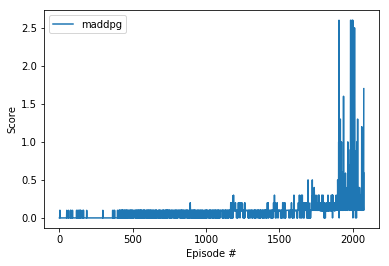

In [9]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label='maddpg')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(loc='upper left');
plt.show()


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 